In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [123]:
#let's replace spaces in titles
titles = {k:k.replace(k,k.strip()) for k in life_df.columns}
life_df.rename(columns=titles,inplace=True)

In [124]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

In [125]:
life_df.head(3)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In the data set we had 21 variables (+1 target value). 
Most of them are numerican and 3 of them are categorical. 
### Let's start with univariate analysis for numerical values.

Let's take a look do we have any missing values or outliers

In [126]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Some of the varialbles has missing values on purpose or data just unavailable by countries. We will fill Hepatitis B, GDP and Population with Interpolation  methiod grouped by country and will drop the countries that didin't provide data


In [127]:
fill_list = ["Life expectancy", "Adult Mortality", "Alcohol",
             "Hepatitis B", "BMI", "Polio",
             "Total expenditure", "Diphtheria",
             "GDP", "Population", "thinness  1-19 years",
             "thinness 5-9 years", "Income composition of resources", "Schooling"]

countries = life_df["Country"].unique()

for country in countries:
    life_df.loc[life_df["Country"] == country, fill_list] = life_df.loc[life_df["Country"] == country, fill_list].interpolate()

# we drop the null values after interpolation since we can't use any average for the countries
life_df.dropna(inplace=True)

In [128]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2937
Data columns (total 22 columns):
Country                            1987 non-null object
Year                               1987 non-null int64
Status                             1987 non-null object
Life expectancy                    1987 non-null float64
Adult Mortality                    1987 non-null float64
infant deaths                      1987 non-null int64
Alcohol                            1987 non-null float64
percentage expenditure             1987 non-null float64
Hepatitis B                        1987 non-null float64
Measles                            1987 non-null int64
BMI                                1987 non-null float64
under-five deaths                  1987 non-null int64
Polio                              1987 non-null float64
Total expenditure                  1987 non-null float64
Diphtheria                         1987 non-null float64
HIV/AIDS                           1987 non-null

now we filled all the missing values. 
Let's find any outliers within the variables so we can clearly estimate the correlation. In this scenario the outliers more likely can happen because of extreme cases in some of the countries the will lead to shifting all of the corellation towards this variable and which might not be relevant for the whole "life expectancy" target.


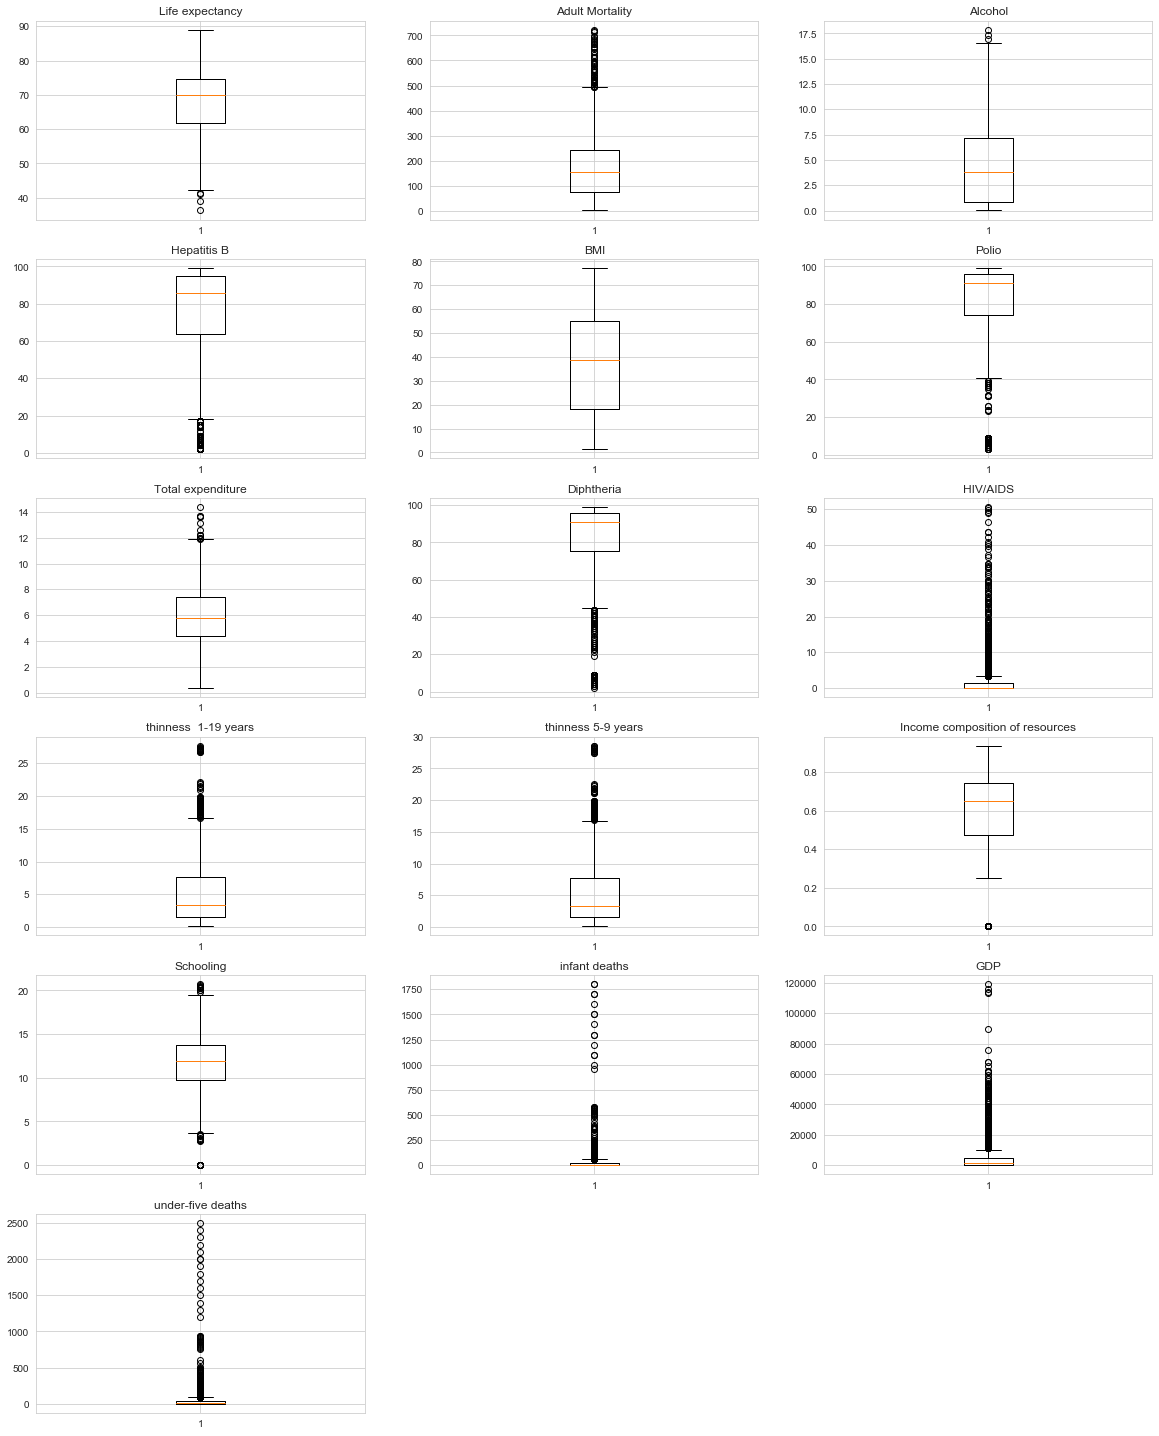

In [129]:
plt.figure(figsize=(20,30))
col_dict = {'Life expectancy':1, 'Adult Mortality':2, 'Alcohol':3, 'Hepatitis B':4,'BMI':5, 'Polio':6, 
            'Total expenditure':7, 'Diphtheria':8, 'HIV/AIDS':9, 'thinness  1-19 years':10,
            'thinness 5-9 years':11,'Income composition of resources':12, 'Schooling':13, 
            'infant deaths':14, 'GDP':15, 'under-five deaths':16,}
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.boxplot(life_df[variable],whis=1.5)
    plt.title(variable)

The resulting box is quite compressed and there seem to be a lot of outliers in the variable. Let's adjust our threshold to  `whis=20`:

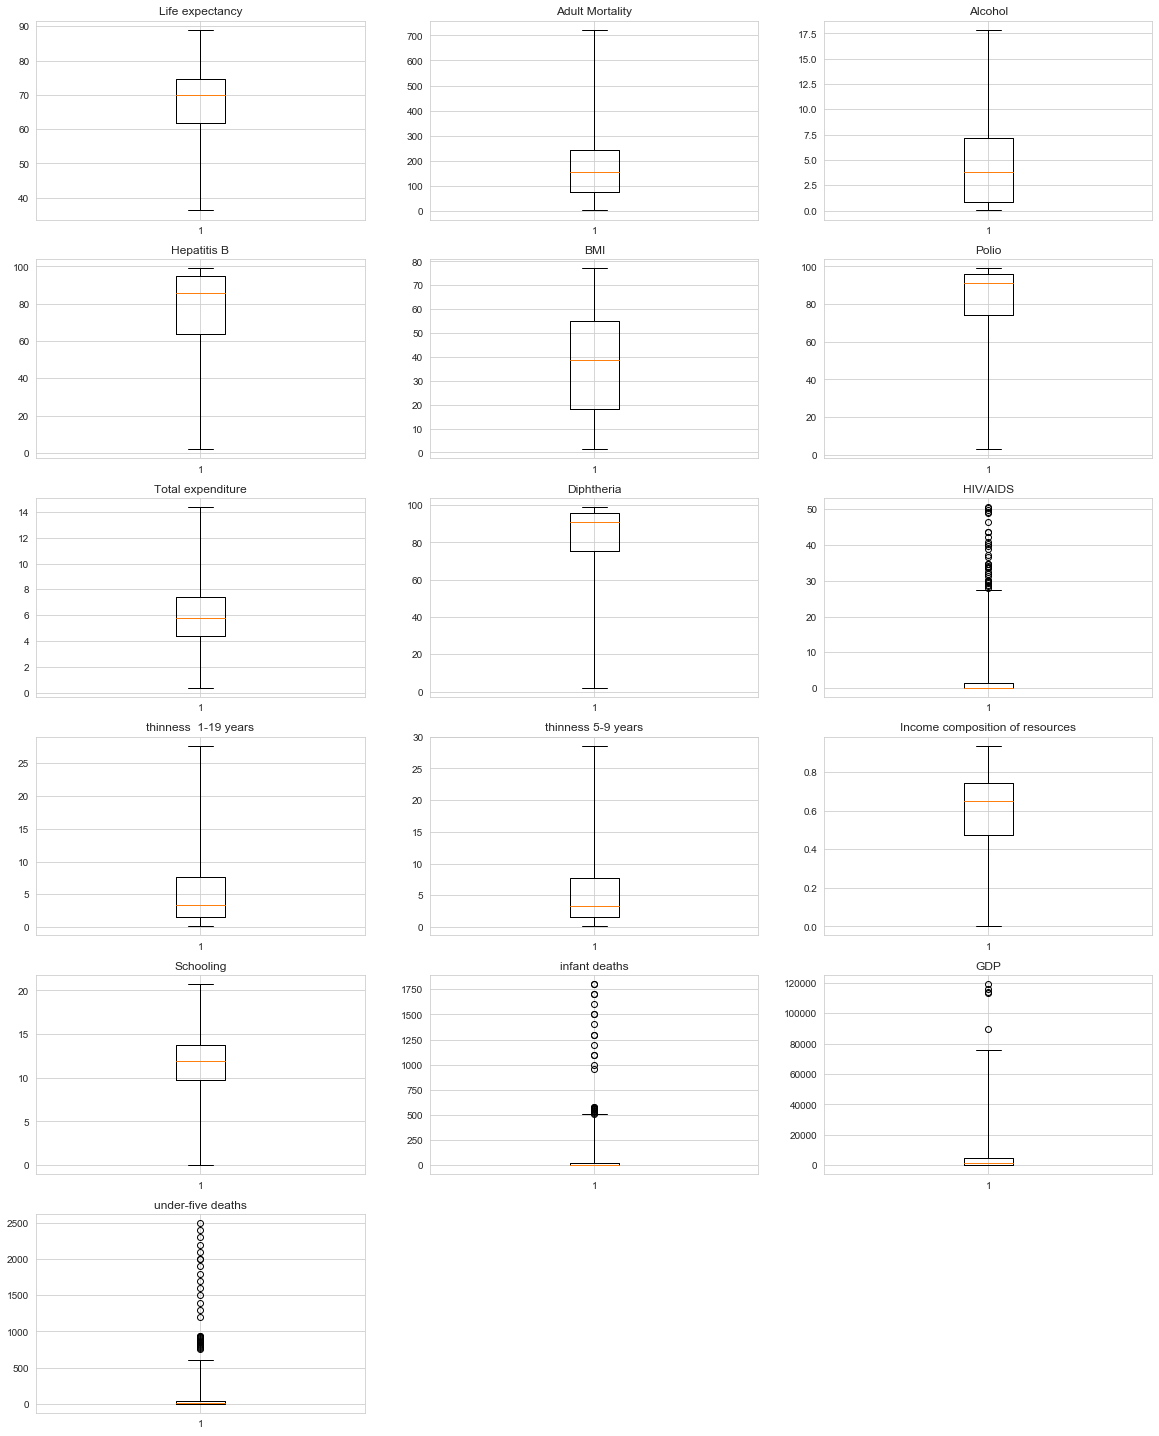

In [130]:
plt.figure(figsize=(20,30))
col_dict = {'Life expectancy':1, 'Adult Mortality':2, 'Alcohol':3, 'Hepatitis B':4,'BMI':5, 'Polio':6, 
            'Total expenditure':7, 'Diphtheria':8, 'HIV/AIDS':9, 'thinness  1-19 years':10,
            'thinness 5-9 years':11,'Income composition of resources':12, 'Schooling':13, 'infant deaths':14, 'GDP':15, 'under-five deaths':16 }
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.boxplot(life_df[variable],whis=20)
    plt.title(variable)

##### The number of outliers decreased this time because we set the threshold quite high. We need to work more on the values: "HIV/AIDS", "infant deaths", "GDP", "under-five deaths. We will limit the values of the outfitters from the top with one-way windsorization technique - we will set the values of the highest end of the distribution to the value of the 95th percentile. 

In [131]:
from scipy.stats.mstats import winsorize

life_df["winsorized_inf_death"] = winsorize(life_df["infant deaths"], (0, 0.05))
life_df["winsorized_undfived"] = winsorize(life_df["under-five deaths"], (0, 0.05))
life_df["winsorized_hiv"] = winsorize(life_df["HIV/AIDS"], (0, 0.05))
life_df["winsorized_gdp"] = winsorize(life_df["GDP"], (0, 0.05))

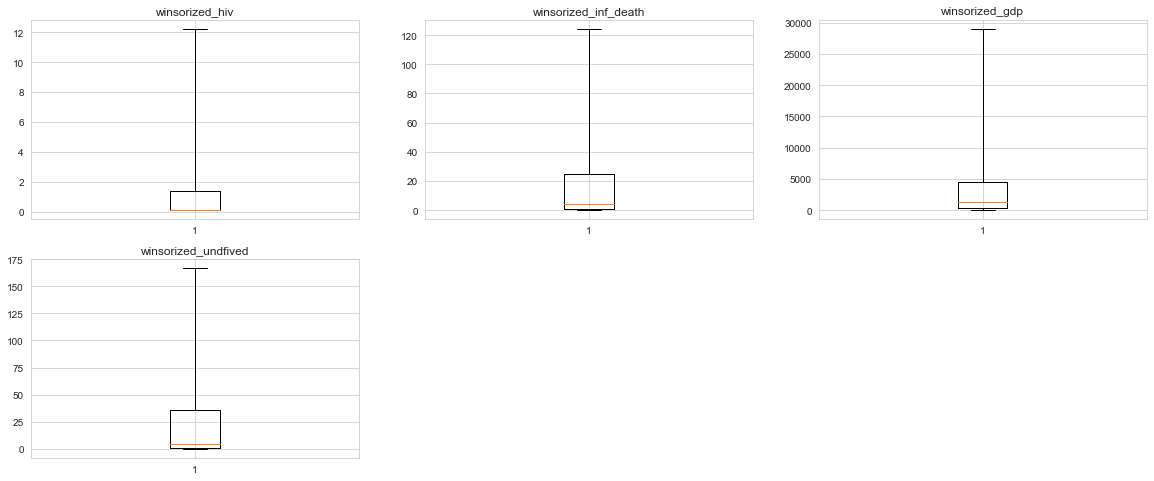

In [132]:
#let's check the winsorized values
plt.figure(figsize=(20,30))
col_dict = {'winsorized_hiv':1,'winsorized_inf_death':2, 'winsorized_gdp':3, 'winsorized_undfived':4 }
for variable, i in col_dict.items():
    plt.subplot(7,3,i) 
    plt.boxplot(life_df[variable],whis=20)
    plt.title(variable)

As we can see, the box plot reveals no outliers after winsorization.

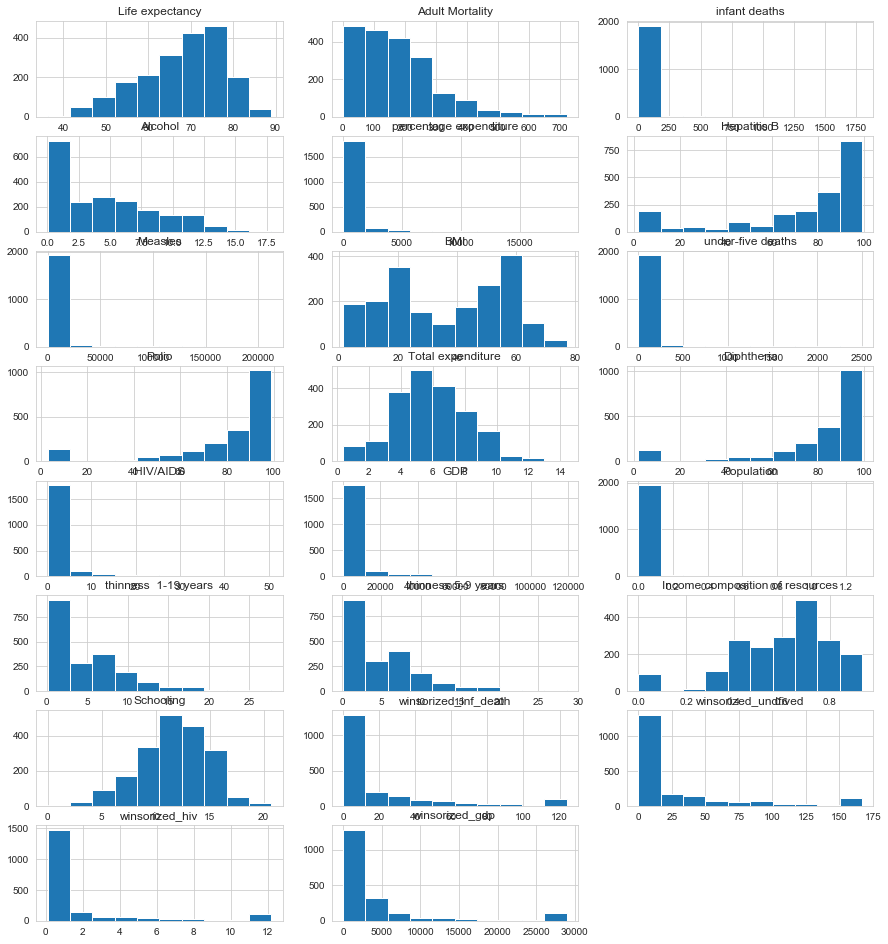

In [133]:
#Now let's procceed with the univariate analysis and find out how the variable distribution looking
i = 0
plt.figure(figsize = (15,25))    
for col in life_df.columns:
    i = i+1
    if col not in ["Country", "Year", "Status"]:
        plt.subplot(12, 3, i)
        plt.hist(life_df[col])
        plt.title(col)
plt.show()

Some variables visually not normally distributed. We will use the monotonic transformations approach - log transformation for some of them.  This will help us apply statistical techniques for future analysis. 


In [134]:
life_df["log_wind_infant deaths"] = np.log(life_df["winsorized_inf_death"])
life_df["log_winsorized_hiv"] = np.log(life_df["winsorized_hiv"])
life_df["log_winsorized_gdp"] = np.log(life_df["winsorized_gdp"])
life_df["log_Adult Mortality"] = np.log(life_df["Adult Mortality"])
life_df["log_Alcohol"] = np.log(life_df["Alcohol"])
life_df["log_Measles"] = np.log(life_df["Measles"])
life_df["log_percentage expenditure"] = np.log(life_df["percentage expenditure"])
life_df["log_under-five deaths"] = np.log(life_df["under-five deaths"])
life_df["log_BMI"] = np.log(life_df["BMI"])
life_df["log_GDP"] = np.log(life_df["GDP"])
life_df["Population"] = np.log(life_df["Population"])

## Univariate visualization of categorical variables

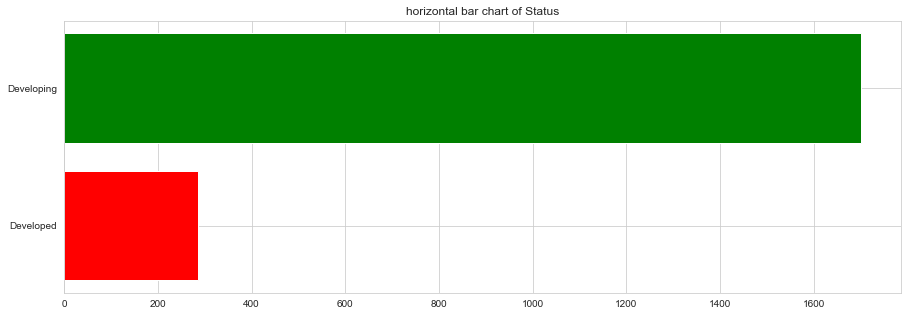

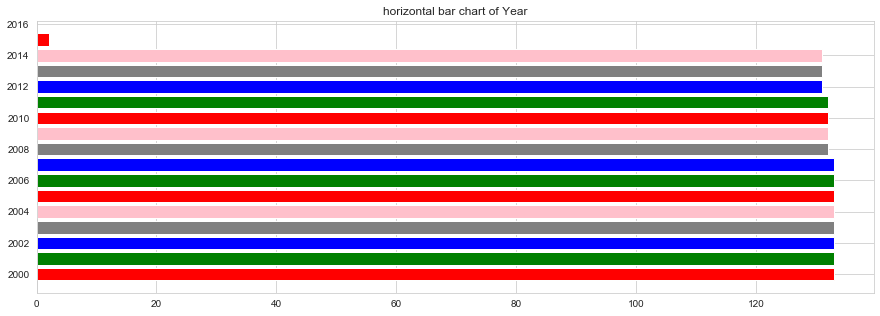

In [135]:
# bar chart of Status
plt.figure(figsize=(15,5))
plt.barh(life_df.groupby("Status")["Status"].count().index, 
        life_df.groupby("Status")["Status"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of Status")

plt.show()
# bar chart of Year
plt.figure(figsize=(15,5))
plt.barh(life_df.groupby("Year")["Year"].count().index, 
        life_df.groupby("Year")["Year"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of Year")

plt.show()


Data set contains most of the data for Developing countries which we should note in building the model and predicting the results. If we would like to predict Life expectancy for Developed countries we need to be careful. We have a good distributions of dasa for two other categorical values as year and country. It has most of dsts for years from 2000-2016

In [136]:
life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_wind_infant deaths,log_winsorized_hiv,log_winsorized_gdp,log_Adult Mortality,log_Alcohol,log_Measles,log_percentage expenditure,log_under-five deaths,log_BMI,log_GDP
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1987.000000,1987.000000,1987.000000,...,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
mean,2006.984902,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2729.561651,36.428636,50.932562,...,-inf,-1.022849,7.145951,4.762329,0.494628,-inf,-inf,-inf,3.359266,7.167947
std,4.323147,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,12102.389143,19.736138,188.933117,...,NaN,1.654709,1.767825,1.090920,2.104729,NaN,NaN,NaN,0.807145,1.810136
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,0.000000,1.400000,0.000000,...,-inf,-2.302585,0.519597,0.000000,-4.605170,-inf,-inf,-inf,0.336472,0.519597
25%,2003.000000,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,0.000000,18.150000,1.000000,...,0.000000,-2.302585,5.952077,4.317488,-0.186330,-inf,3.383367,0.000000,2.898667,5.952077
50%,2007.000000,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,20.000000,38.700000,4.000000,...,1.386294,-2.302585,7.196426,5.030438,1.327075,2.995732,4.647410,1.386294,3.655840,7.196426
75%,2011.000000,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,499.500000,55.000000,36.000000,...,3.218876,0.336472,8.398754,5.493061,1.972691,6.213567,6.154581,3.583519,4.007333,8.398754
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,18961.348600,99.00000,212183.000000,77.100000,2500.000000,...,4.820282,2.501436,10.273365,6.583409,2.883123,12.265204,9.850158,7.824046,4.345103,11.688329


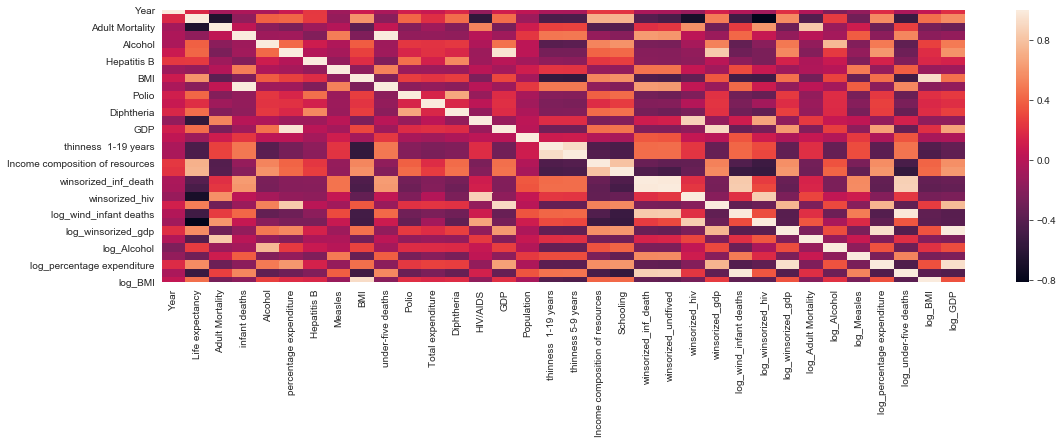

In [137]:
#It will be a good idea to remove all corelated variable that correlate with each other.

plt.figure(figsize=(18,5))

sns.heatmap(life_df.corr())
plt.show()

In [138]:
#Let's see the correlation in a descending order
np.abs(life_df.iloc[:,1:].corr().loc[:,"Life expectancy"]).sort_values(ascending=False)

Life expectancy                    1.000000
log_winsorized_hiv                 0.814819
Schooling                          0.744703
Income composition of resources    0.726753
winsorized_hiv                     0.695866
Adult Mortality                    0.660529
BMI                                0.599572
HIV/AIDS                           0.576373
log_GDP                            0.566903
log_percentage expenditure         0.563601
log_winsorized_gdp                 0.562549
log_under-five deaths              0.535872
winsorized_gdp                     0.507966
log_wind_infant deaths             0.505536
winsorized_undfived                0.461193
thinness  1-19 years               0.458724
thinness 5-9 years                 0.450095
log_BMI                            0.448603
GDP                                0.443612
Diphtheria                         0.442943
Polio                              0.415188
log_Adult Mortality                0.413878
percentage expenditure          

In [139]:
#let's see what variables can affect life expectancy in a negative way
life_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_wind_infant deaths,log_winsorized_hiv,log_winsorized_gdp,log_Adult Mortality,log_Alcohol,log_Measles,log_percentage expenditure,log_under-five deaths,log_BMI,log_GDP
Year,1.000000,0.171485,-0.072108,-0.037601,-0.046859,0.089096,0.247259,-0.099554,0.096059,-0.042479,...,-0.019565,-0.086395,0.201539,-0.019838,-0.234224,-0.146152,0.187094,-0.045680,0.056952,0.202452
Life expectancy,0.171485,1.000000,-0.660529,-0.160922,0.392617,0.413683,0.249625,-0.138133,0.599572,-0.187438,...,-0.505536,-0.814819,0.562549,-0.413878,0.256288,-0.284426,0.563601,-0.535872,0.448603,0.566903
Adult Mortality,-0.072108,-0.660529,1.000000,0.038304,-0.181469,-0.242438,-0.103382,-0.007269,-0.372519,0.052865,...,0.257531,0.604516,-0.310403,0.832787,-0.116872,0.104548,-0.306562,0.271682,-0.265562,-0.313561
infant deaths,-0.037601,-0.160922,0.038304,1.000000,-0.104406,-0.089772,-0.216949,0.509747,-0.227769,0.996729,...,0.420431,0.067020,-0.142905,0.014428,-0.075241,0.380278,-0.176939,0.542007,-0.181808,-0.142710
Alcohol,-0.046859,0.392617,-0.181469,-0.104406,1.000000,0.430835,0.106383,-0.029252,0.379327,-0.099713,...,-0.353048,-0.184436,0.485258,-0.155128,0.763873,-0.213988,0.495127,-0.365977,0.281197,0.491940
percentage expenditure,0.089096,0.413683,-0.242438,-0.089772,0.430835,1.000000,-0.011530,-0.069316,0.277788,-0.092480,...,-0.298040,-0.240859,0.546711,-0.207756,0.251549,-0.146348,0.616652,-0.300828,0.196163,0.591997
Hepatitis B,0.247259,0.249625,-0.103382,-0.216949,0.106383,-0.011530,1.000000,-0.142059,0.198627,-0.226512,...,-0.171119,-0.241028,0.140158,-0.041627,0.081036,-0.227759,0.136137,-0.219597,0.170035,0.135481
Measles,-0.099554,-0.138133,-0.007269,0.509747,-0.029252,-0.069316,-0.142059,1.000000,-0.168172,0.519173,...,0.317458,0.077479,-0.101868,-0.032431,0.004125,0.493463,-0.134286,0.383518,-0.121909,-0.101996
BMI,0.096059,0.599572,-0.372519,-0.227769,0.379327,0.277788,0.198627,-0.168172,1.000000,-0.238155,...,-0.489484,-0.497947,0.456030,-0.280519,0.287573,-0.336994,0.453315,-0.509579,0.924203,0.455847
under-five deaths,-0.042479,-0.187438,0.052865,0.996729,-0.099713,-0.092480,-0.226512,0.519173,-0.238155,1.000000,...,0.430120,0.094831,-0.152233,0.022685,-0.071427,0.385830,-0.183415,0.553240,-0.189479,-0.151900


Now, apply PCA to the four expenditure types. How much of the total variance is explained by the first component?

We would be still using the variables/transformed variables for building the model that are mostly correlated with our target:
- Schooling (positive impact)
- Income composition of resources (positive impact)
- winsorized_hiv (negativer impact)
- Adult Mortality (negativer impact)
- BMI(positive impact)
- winsorized_gdp (positive impact)
Below is the description for these variables

In [141]:
life_df[["log_winsorized_hiv", "Schooling", "Income composition of resources", 
         "Adult Mortality",'BMI', 'winsorized_gdp']].describe()

,log_winsorized_hiv,Schooling,Income composition of resources,Adult Mortality,BMI,winsorized_gdp
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
mean,-1.022849,11.639054,0.603453,175.187217,36.428636,4473.568560
std,1.654709,3.212964,0.206026,131.616942,19.736138,7415.895154
min,-2.302585,0.000000,0.000000,1.000000,1.400000,1.681350
25%,-2.302585,9.700000,0.473000,75.000000,18.150000,384.553107
50%,-2.302585,11.900000,0.648000,153.000000,38.700000,1334.651896
75%,0.336472,13.700000,0.745000,243.000000,55.000000,4441.530655
max,2.501436,20.700000,0.936000,723.000000,77.100000,28951.155560
